# ImpPres LLM Baseline

You have to implement in this notebook a baseline for ImpPres classification using an LLM.
This baseline must be implemented using DSPy.



In [3]:
# Configure the DSPy environment with the language model - for grok the parameters must be:
# env variable should be in os.environ['XAI_API_KEY']
# "xai/grok-3-mini"
import os
import dspy
import api_key

lm = dspy.LM('xai/grok-3-mini', api_key=api_key.grok_key)
# for ollama 
# lm = dspy.LM('ollama_chat/devstral', api_base='http://localhost:11434', api_key='')
dspy.configure(lm=lm)

In [5]:
from typing import Literal

class NLIClassifier(dspy.Signature):
    """Classify a premise-hypothesis pair as entailment, contradiction, or neutral."""
    premise = dspy.InputField(desc="The premise sentence")
    hypothesis = dspy.InputField(desc="The hypothesis sentence")
    label = dspy.OutputField(
        desc="The NLI relation: entailment, contradiction, or neutral",
        format=Literal["entailment", "contradiction", "neutral"]
    )

class NLIProgram(dspy.Program):
    def __init__(self):
        super().__init__()
        self.classifier = dspy.Predict(NLIClassifier)

    def forward(self, premise: str, hypothesis: str):
        result = self.classifier(premise=premise, hypothesis=hypothesis)
        return result.label

## Load ImpPres dataset

In [ ]:
from datasets import load_dataset

sections = ['presupposition_all_n_presupposition', 
            'presupposition_both_presupposition', 
            'presupposition_change_of_state', 
            'presupposition_cleft_existence', 
            'presupposition_cleft_uniqueness', 
            'presupposition_only_presupposition', 
            'presupposition_possessed_definites_existence', 
            'presupposition_possessed_definites_uniqueness', 
            'presupposition_question_presupposition']

dataset = {}
for section in sections:
    print(f"Loading dataset for section: {section}")
    dataset[section] = load_dataset("facebook/imppres", section)

In [ ]:
dataset

## Evaluate Metrics

Let's use the huggingface `evaluate` package to compute the performance of the baseline.


In [7]:
import evaluate
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

## Your Turn

Compute the classification metrics on the baseline LLM model on each test section of the ANLI dataset for samples that have a non-empty 'reason' field.

You also must show a comparison between the DeBERTa baseline model and this LLM baseline model. The comparison metric should compute the agreement between the two models:
* On how many samples they are both correct [Correct]
* On how many samples Model1 is correct and Model2 is incorrect [Correct1]
* On how many samples Model1 is incorrect and Model2 is correct [Correct2]
* On how many samples both are incorrect [Incorrect]

In [ ]:
import pandas as pd

model1_df = pd.read_csv("baseline_results.csv")
print("Loaded Model1 results:", model1_df.shape)
other_df = pd.read_csv("combined_presuppositions.csv")
print("Loaded Model1 results:", other_df.shape)

model1_df['section'] = other_df['section']
model1_df.head()

In [27]:
def evaluate_with_dspy(df):
    df_filtered = df.groupby('section').apply(lambda x: x.sample(n=50, random_state=42) if len(x) >= 50 else x).reset_index(drop=True)
    program = NLIProgram()
    results = []
    for _, row in df_filtered.iterrows():
        pred_label = program.forward(premise=row["premise"], hypothesis=row["hypothesis"])
        results.append({
            "premise": row["premise"],
            "hypothesis": row["hypothesis"],
            "gold_label": row["gold_label"],
            "model1_pred_label": row["pred_label"],
            "model2_pred_label": pred_label,
            "section": row["section"]
        })
    return pd.DataFrame(results)
comparison_df = evaluate_with_dspy(model1_df)


C:\Users\idol\AppData\Local\Temp\ipykernel_22488\1834294443.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df.groupby('section').apply(lambda x: x.sample(n=50, random_state=42) if len(x) >= 50 else x).reset_index(drop=True)


In [29]:
comparison_df.to_csv("comparison_baseline_llm.csv", index=False)

In [26]:
comparison_df.head(10)

,premise,hypothesis,gold_label,model1_pred_label,model2_pred_label,section
0,Had the four peppers that fell gone bad?,There are exactly four peppers that fell.,entailment,neutral,entailment,all_n_presupposition
1,Do both adults that were appearing date?,There are exactly two adults that were appearing,entailment,neutral,entailment,both_presupposition
2,Does Travis hire Alexander?,Alexander is unemployed.,entailment,contradiction,neutral,change_of_state
3,Is it that person that finds out who doesn't t...,Someone finds out who doesn't talk about Carrie,entailment,neutral,entailment,cleft_existence
4,Is it Daniel that had required Kendra's grandm...,Exactly one person had required Kendra's grand...,entailment,contradiction,neutral,cleft_uniqueness
5,Does Stacey only pressure Rose to conceal Step...,Stacey pressures Rose to conceal Stephanie.,entailment,entailment,entailment,only_presupposition
6,Did Naomi's mountain shock Sharon?,Naomi has a mountain.,entailment,entailment,entailment,possessed_definites_existence
7,Did Diana's story that hadn't disgusted Jill a...,Diana has exactly one story that hadn't disgus...,entailment,neutral,neutral,possessed_definites_uniqueness
8,Did Gary realize why Kenneth does stun Jodi?,Kenneth does stun Jodi,entailment,entailment,neutral,question_presupposition


In [1]:
import pandas as pd

comparison_df = pd.read_csv("comparison_baseline_llm.csv")

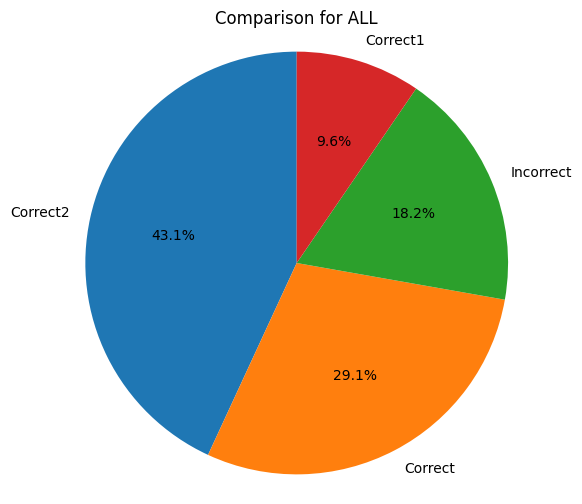

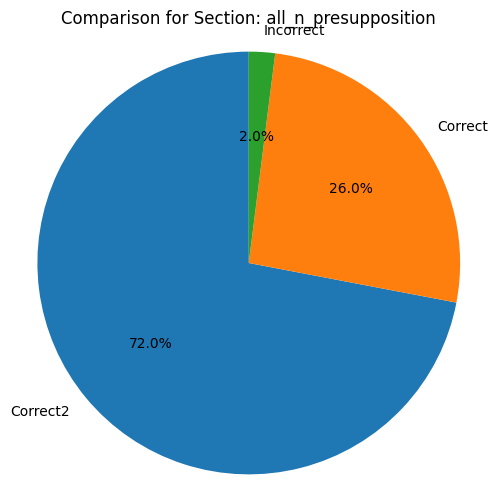

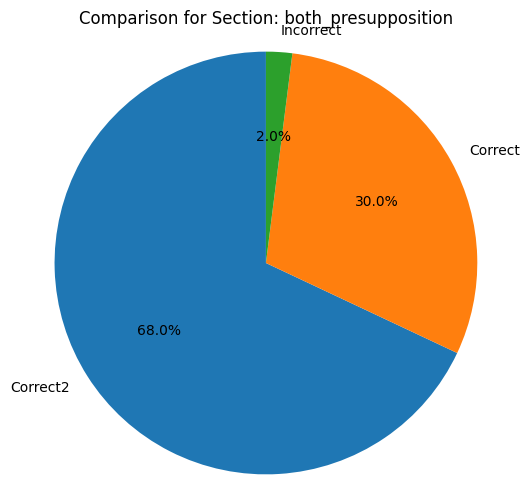

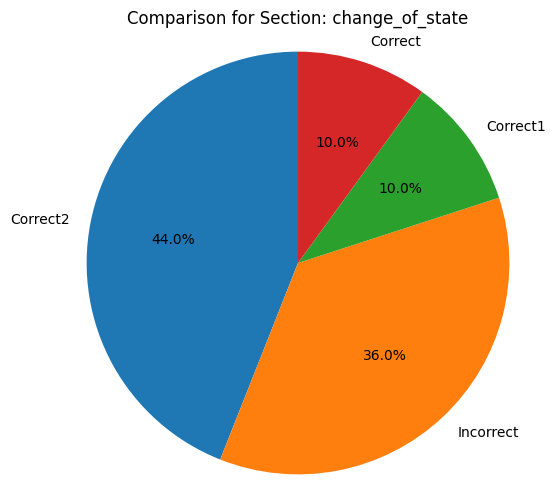

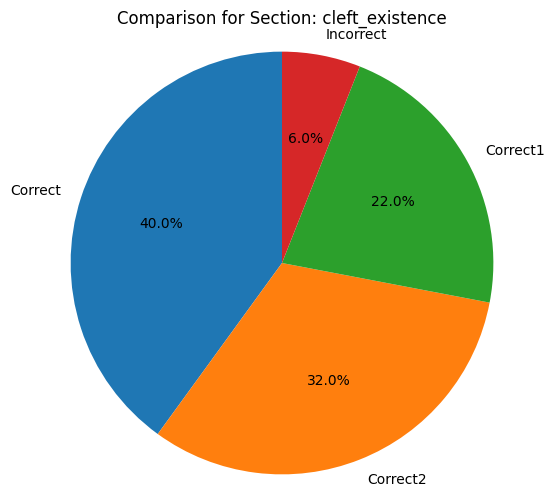

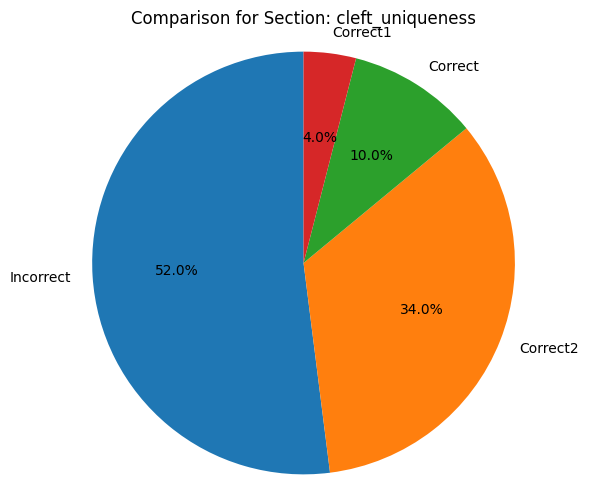

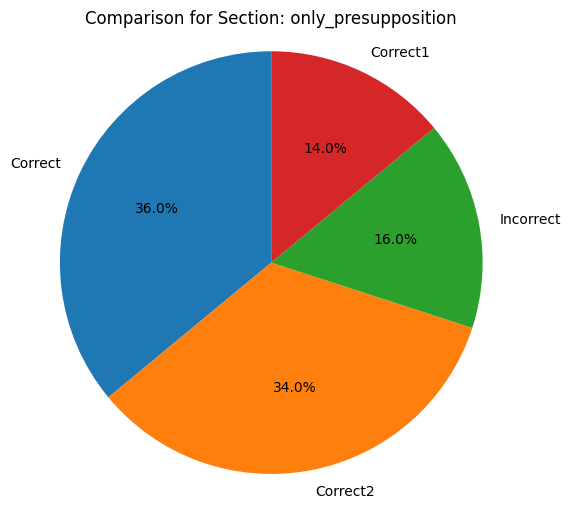

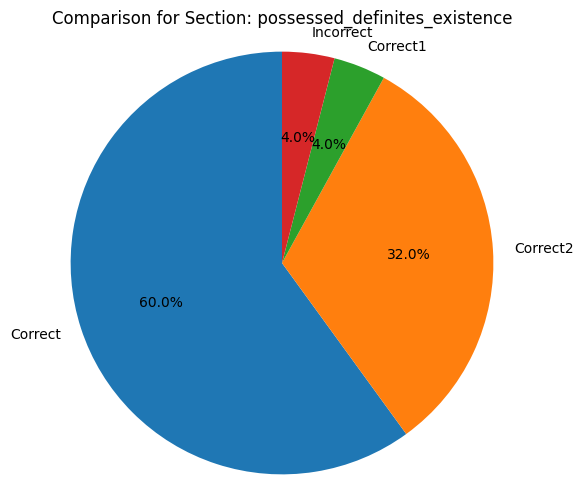

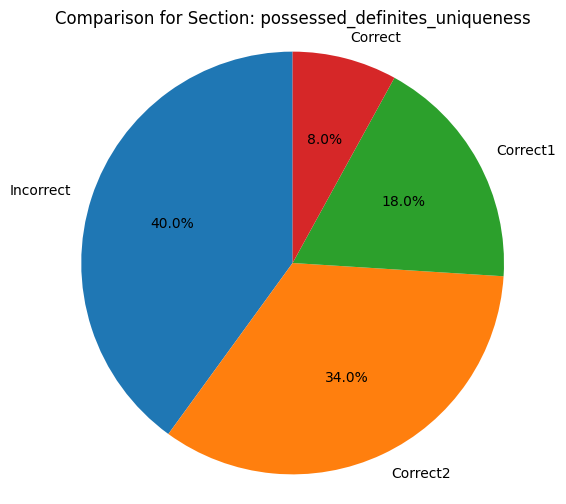

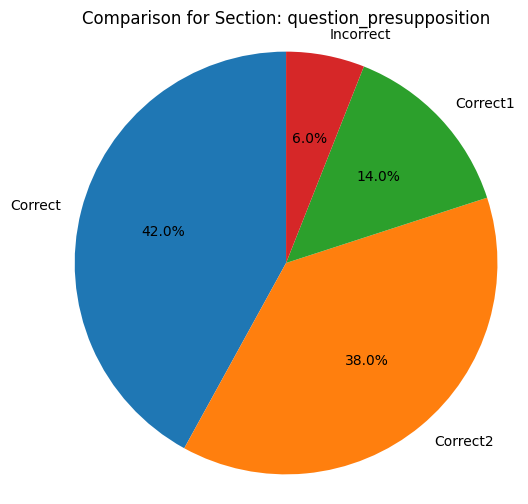

In [9]:
import matplotlib.pyplot as plt
# Add a column for comparison result
def label_row(row):
    m1 = row["model1_pred_label"] == row["gold_label"]
    m2 = row["model2_pred_label"] == row["gold_label"]
    if m1 and m2:
        return "Correct"
    elif m1 and not m2:
        return "Correct1"
    elif not m1 and m2:
        return "Correct2"
    else:
        return "Incorrect"

comparison_df["comparison_result"] = comparison_df.apply(label_row, axis=1)

counts = comparison_df["comparison_result"].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 6))
plt.pie(
    counts.values,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title(f"Comparison for ALL")
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()
# Create pie chart for each section
for section in comparison_df["section"].unique():
    section_df = comparison_df[comparison_df["section"] == section]
    counts = section_df["comparison_result"].value_counts(normalize=True) * 100
    
    plt.figure(figsize=(6, 6))
    plt.pie(
        counts.values,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f"Comparison for Section: {section}")
    plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
    plt.show()


In [10]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from IPython.display import display

def analyze_model2(comparison_df, decimals=3):
    sections = []
    
    # Evaluate section by section
    for section, section_df in comparison_df.groupby("section"):
        preds = section_df["model2_pred_label"].tolist()
        refs  = section_df["gold_label"].tolist()

        acc = accuracy_score(refs, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(refs, preds, average="macro", zero_division=0)

        sections.append({
            "section": section,
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1
        })
    
    # Compute overall metrics
    all_preds = comparison_df["model2_pred_label"].tolist()
    all_refs  = comparison_df["gold_label"].tolist()
    acc = accuracy_score(all_refs, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_refs, all_preds, average="macro", zero_division=0)
    sections.append({
        "section": "ALL",
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
    
    metrics_df = pd.DataFrame(sections)
    
    # Round numeric columns safely
    metrics_df_rounded = metrics_df.copy()
    numeric_cols = ["accuracy", "precision", "recall", "f1"]
    for col in numeric_cols:
        if col in metrics_df_rounded.columns:
            metrics_df_rounded[col] = pd.to_numeric(metrics_df_rounded[col], errors="coerce").round(decimals)
    
    # Style the DataFrame
    styled = (
        metrics_df_rounded.style
        .set_table_styles(
            [
                {"selector": "thead th", "props": [("background-color", "#4CAF50"),
                                                   ("color", "white"),
                                                   ("font-weight", "bold"),
                                                   ("text-align", "center")]},
                {"selector": "tbody td", "props": [("text-align", "center")]}
            ]
        )
        .bar(subset=numeric_cols, color="#87A7EBE8")
        .format({col: f"{{:.{decimals}f}}" for col in numeric_cols})
    )
    
    print("\nModel2 Metrics Table:")
    display(styled)
    return metrics_df

# Example usage
metrics_df_model2 = analyze_model2(comparison_df)



Model2 Metrics Table:


,section,accuracy,precision,recall,f1
0,all_n_presupposition,0.980,0.985,0.982,0.983
1,both_presupposition,0.980,0.983,0.984,0.983
2,change_of_state,0.540,0.621,0.486,0.446
3,cleft_existence,0.720,0.867,0.739,0.726
4,cleft_uniqueness,0.440,0.476,0.367,0.261
5,only_presupposition,0.700,0.791,0.693,0.699
6,possessed_definites_existence,0.920,0.933,0.933,0.933
7,possessed_definites_uniqueness,0.420,0.306,0.351,0.249
8,question_presupposition,0.800,0.843,0.828,0.818
9,ALL,0.722,0.822,0.707,0.722
